In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Author: Andrew Tarzia

Date Created: 26 Mar 2018

License:

# Notebook for calculating the relative zinc ion affinity for different models of carbohydrate chains

TODO:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# replace matlab BVP solver with scipy
from scipy.integrate import solve_bvp
import scipy.special as sc
import expressions_sphere as exp_s
from scipy import constants

In [3]:
# constants
KB = constants.Boltzmann # boltzmann constant [J/K]
NA = constants.N_A # avogadros number [mol-1]
e = constants.elementary_charge # elementary charge [C]
E_0 = constants.epsilon_0 # Vacuum permittivity [F/m = C^2/(J.m)]
M_TO_NM = 1.0e9 # conversion from m to nm
M3_TO_L = 1.0e3 # conversion from m^3 to L
PI = constants.pi

## Set polymer variables

In [4]:
# Lc is approximate monomer length (length of Glucose unit)
Lc = 5 # angstrom
# DP is the number of monomers in carbohydrate chain
# or degree of polymerisation DP
# set such that MW is arround 3200 Da
DP = 60

## Determine pervaded volume

In [5]:
# from literature:
# - Carboxymethyl and native dextran behave as freely jointed chains
# - Kuhn length is approximately the same as the length of the glucose monomer
# calculate radius of gyration Rg using equation for Freely Jointed Chain
Rg_2 = (DP * (Lc ** 2)) / 6
Rg = np.sqrt(Rg_2)
print("radius of gyration =", round(Rg, 3), "angstrom")

# calculate the pervaded volume as the volume of a sphere with radius == Rg
Vg = (4/3) * PI * (Rg ** 3)
print("pervaded volume =", round(Vg, 3), "angstrom^3")

radius of gyration = 15.811 angstrom
pervaded volume = 16557.647 angstrom^3


##  Set Solution variables

In [6]:
# set temp
T = 298 # [K]
# thermal voltage [V]
Vt = KB*T/(e)
# set relative permittivity [unit less] -- water!
E_r = 78.46
# set pH of solution
PH = 11
# salt concs (1 = Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = 2  # zinc 2+
Z2 = -1  # co-ion

## Determine total polymer charge as a function of DS

In [146]:
func_colors = {"COO": 'firebrick', "NH2": 'royalblue'}  # set plot colours for the different functionalities

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for R per glucose (max at 3, for 3 OH per glucose)
# vary the degree of substitution
DS = np.linspace(0, 1.0, 20)
# the total number of charge centres on the chain based on the DS and DP
func_count = DS * DP

# set charge and pka of functionalisations
func_charges = {"COO": -1, "NH2": +1}
func_pkas = {"COO": 4, "NH2": 12}  #### UPDATE THESE 

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    pka = func_pkas[func]
    charge = func_charges[func]
    partial_charge = exp_s.calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


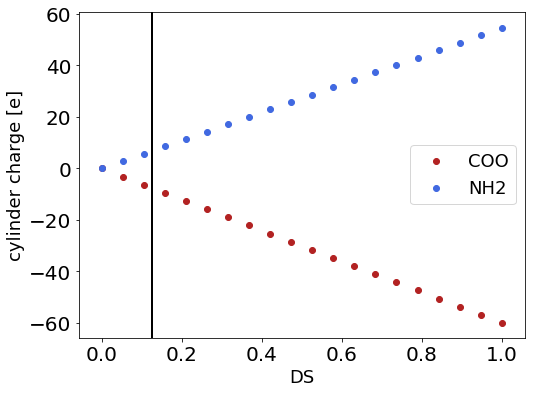

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.scatter(DS, func_total_charges[func], c=func_colors[func], label=func)

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("cylinder charge [e]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)

ax.axvline(x=0.125, c='k', lw=2)

plt.show()

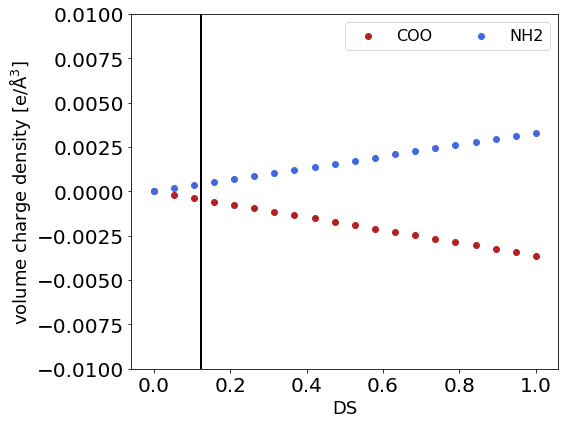

In [148]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.tick_params(axis='both', which='major', labelsize=20)
for func in func_charges.keys():
    # calculate volume charge density as total charge / Volume
    Vg_q = func_total_charges[func] / Vg  # e/angstrom^3
    ax1.scatter(DS, Vg_q, c=func_colors[func], label=func)
    
# ax1.set_title('volume charge density', fontsize=18)
ax1.set_xlabel("DS", fontsize=18)
ax1.set_ylabel('volume charge density [e/$\mathrm{\AA}^3$]', fontsize=18)
ax1.axvline(x=0.125, c='k', lw=2)
ax1.set_ylim(-0.01, 0.01)

ax1.legend(fancybox=True, ncol=2,
           #bbox_to_anchor=(1.5, -0.3),
           fontsize=16)
fig.tight_layout()
fig.savefig('../../documents/images/cylinder_model_spherical_vcd.pdf', dpi=720, bbox_inches='tight')

## Functions for numerical solution of PB Eqn

In [149]:
def fun_1(rr, y):
    """Poisson-Boltzmann equation in cylindrical coords.
    Spherical - reduced coordinates
    reduced parametrs: psi(r) = PSI
    
    y(1)  = psi(r)
    y(1)' = dpsi / dr = y(2) / r^2
    y(2)  = r^2 (dpsi / dr) = r^2 * y(1)
    y(2)' = r^2 ( (-e / epsilon)[sum(zi ni exp(-zi*psi(r)))] - (rho(r) / epsilon)  )
        
    rr in m
    everything in SI
    n+, n- in: 
    
    """
    global z_m
    global n_p
    global n_m
    global epsilon
    global vg
    global rg

    rho = np.zeros(rr.size)
    rho[rr <= rg] = vg 
    
    #print(rho)
    
    dydr = np.vstack([y[1] / (rr ** 2),
                       (rr ** 2) * ((-e / epsilon) * (z_p * n_p * np.exp(-z_p * y[0]) + z_m * n_m * np.exp(-z_m * y[0])) - (rho / epsilon))])
    
    
    #print((rr ** 2) * ((-4 * PI * e / epsilon) * (z_p * n_p * np.exp(-z_p * y[0]) + z_m * n_m * np.exp(-z_m * y[0])) - (4 * PI * rho / epsilon)))
    return dydr

def fun_2(rr, y):
    """Poisson-Boltzmann equation in cylindrical coords.
    Spherical - reduced coordinates
    reduced parametrs: psi(r) = PSI
    
    y(1)  = psi(r)
    y(1)' = dpsi / dr = y(2) / r^2
    y(2)  = r^2 (dpsi / dr) = r^2 * y(1)
    y(2)' = 
        
    rr in m
    everything in SI
    
    """
    global kappasq_si
    global epsilon
    global vg # C/m^3
    global rg

    rho = np.zeros(rr.size)
    rho[rr <= rg] = vg 

    dydr = np.vstack([y[1] / (rr ** 2),
                     (rr ** 2) * (((kappasq_si / epsilon) * (y[0])) - (rho / epsilon))])
    
    #print((rr ** 2) * ((-4 * PI * e / epsilon) * (z_p * n_p * np.exp(-z_p * y[0]) + z_m * n_m * np.exp(-z_m * y[0])) - (4 * PI * rho / epsilon)))
    return dydr

# -----------------------------------------------------------------------

def bc(ya, yb):
    """BCs for Poisson-Boltzmann equation in cylindrical coords.
    Boundary conditions for Poisson-Boltzmann equation in cylindrical
    coordinates in reduced units:
      y(1) = psir = z*e/(k*T)*psi
      y(2) = rr*dpsir/drr  (rr = r/radius)
      y(2) = 0 at r=0 
      y(2) = z*e*sig*radius/(eps0*eps*k*T) = sigr
      
    redefined:
        if:
          y(1) = psir = z*e/(k*T)*psi
          y(2) = rr*dpsir/drr  (rr = r/radius)
        BCs:
          y(1)' = 0 at r=0
          y(2)  = 0 at r=R
              
    notes:
        ya[0] implies the function y at first boundary a
        ya[1] implies the function y' at first boundary a
        yb[0] implies the function y at second boundary b
        yb[1] implies the function y' at second boundary b
                      
    """
    
    res = [ya[1],
           yb[0]]
    return res

# -----------------------------------------------------------------------

def pb_cylinder_init(rr, init_pot_red):
    """Initial guess for solution to PB eqn in spherical coords.
    
    initial mesh:
        [from analytical solution Ohshima, 93]
        at r == 0 (y[0, 0]), potential = rho/(eps_0 * eps_r * kappa ** 2) == e * rho / (kb * T * eps_0 * eps_r * kappa ** 2) in reduced potential units 
        at r = Rmax (y[0, 1]), potential == 0
    """
    yinit = np.zeros((2, rr.size))
    yinit[0, 0] = init_pot_red
    yinit[0, 1] = 0
    
    return yinit

In [150]:
def calculate_kappasq(e, I, e0, eR, KB, T, PI):
    """
    Calculate kappa^2 (== debye length ^ (-1/2)) in m^-2 (SI units)
    
    """
    top = 2 * (e ** 2) * I 
    bottom = e0 * eR * KB * T
    
    kappasq = top / bottom
    
    return kappasq

In [151]:
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * M3_TO_L  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
kappasq = calculate_kappasq(e, I_m, E_0, E_r, KB, T, PI) # m^-2
kappa = np.sqrt(kappasq) # m^-1
print('kappa^2 =', round(kappasq, 3), 'm^-2')
print('kappa =', kappa * (10 ** -20), 'angstrom^-1')
print('debye length =', round(1/np.sqrt(kappasq * (10 ** -20)), 3), 'angstrom')
print("-------------------------------")

-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 1.2980352954683128e+18 m^-2
kappa = 1.1393135193915293e-11 angstrom^-1
debye length = 8.777 angstrom
-------------------------------


In [152]:
resolution = 1  # angstrom
max_r = 500  # angstrom
radius_to_incl = 0.74  # zinc ion radius in angstrom
# number of nodes to include radius on either side
nodes_incl = int(radius_to_incl / resolution)

In [153]:
# radial positions from centre of cylinder in angstrom
# initial guess at solution.
# we know that at r == 0 (centre of sphere) the potential must <= XX from Wall paper (https://doi.org/10.1063/1.1743234)
# we know that at r == Rmax (or infinity), the potential must  == 0
r_in = np.asarray([0.00001, max_r])
r_out = np.linspace(0, max_r, int(max_r / resolution))

In [154]:
# plotting switches
plot_summary = False
plot_analytical = False  # we do not have an analytical comparison for now

=================== COO ==================
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True The algorithm converged to the desired accuracy. 0
True 

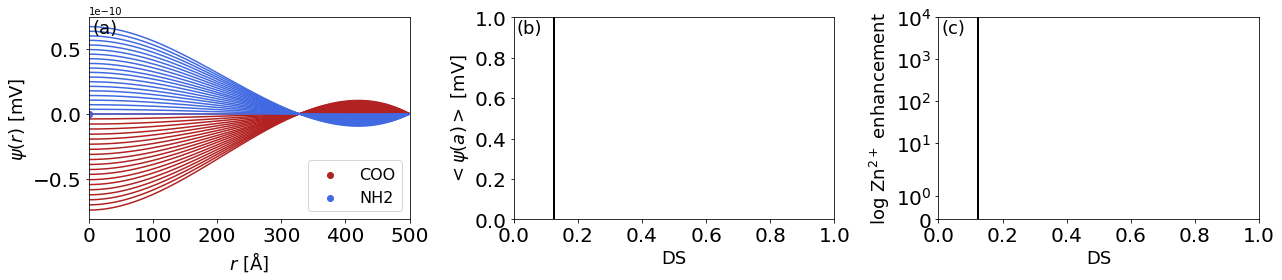

In [158]:
fig = plt.figure(figsize=(18, 4))
ax1 = plt.subplot(131)
ax1.tick_params(axis='both', which='major', labelsize=20)
# label
ax1.text(0.01, 0.9, '(a)',
         verticalalignment='bottom', horizontalalignment='left',
         transform=ax1.transAxes,
         fontsize=18)

ax2 = plt.subplot(132)
ax2.tick_params(axis='both', which='major', labelsize=20)
# label
ax2.text(0.01, 0.9, '(b)',
         verticalalignment='bottom', horizontalalignment='left',
         transform=ax2.transAxes,
         fontsize=18)

ax3 = plt.subplot(133)
ax3.tick_params(axis='both', which='major', labelsize=20)
# label
ax3.text(0.01, 0.9, '(c)',
         verticalalignment='bottom', horizontalalignment='left',
         transform=ax3.transAxes,
         fontsize=18)

func_surface_concentration = {}
for func in func_charges.keys():
    print("===================", func, "==================")
    # collect data for each DS
    psi_= []
    for i, ds in enumerate(DS):
        # calculate volume charge density as total charge / Volume
        Vg_q = func_total_charges[func][i] / Vg  # e/angstrom^3
        Vg_q_si = Vg_q * e * (10 ** 30) # C/m^3
        Rg_si = Rg * (10 ** -10) # m
        r_in_si = r_in * (10 ** -10) # m
        r_out_si = r_out * (10 ** -10) # m
        n_p_si = salt1_conc * NA * M3_TO_L  # m^-3
        n_m_si = salt2_conc * NA * M3_TO_L  # m^-3
        
        
        # reduce all distance units by kappa (m^-1)
        Vg_q_k = Vg_q_si * (kappa ** -3)
        Rg_k = Rg_si * kappa
        r_in_k = r_in_si * kappa
        r_out_k = r_out_si * kappa
        n_p_k = salt1_conc * (kappa ** -3)
        n_m_k = salt2_conc * (kappa ** -3)
        
        # set params for BVP
        vg = Vg_q_si
        rg = Rg_si
        n_p = n_p_si
        n_m = n_m_si
        z_p = Z1
        z_m = Z2
        epsilon = E_0 * E_r
        #p = z_p, z_m, n_p, n_m, eps, e, vg, rg, PI\n",

        # get intial solution
        init_pot = Vg_q_si / (epsilon * kappasq)
        init_pot_red = init_pot * e / (KB * T)
        if i == 0:
            solInit = pb_cylinder_init(r_in_si, init_pot_red=init_pot_red)
            y = solInit
            in_x = r_in_si
        else:
            # use previous solution as input to current run
            in_x = solution.x
            y = solution.y
            
        # solve!
        # fun = RHS of system of ODEs
        # bc = boundary conditions
        # x = initial mesh
        # y = initial guess
        #sol = solve_bvp(pb_cylinder_ode(r,y,kappasqr), pb_cylinder_bc(r,y,sigr), r, y)#,p=[kappasqr,sigr])
        #solution = solve_bvp(fun_1, bc, r_in_si, y, max_nodes=r_in.size) #, verbose=2)
        solution = solve_bvp(fun_1, bc, in_x, y) #, max_nodes=r_in.size) #, verbose=2)

        print(solution.success, solution.message, solution.status)
        
        # reduced radial coord. (for output)        
        # reduced electrostatic potential
        # output the values of sol for all r
        psir = solution.sol(r_out_si)[0]

        # electrostatic potential [mV]
        psi = psir * 1000
        psi_.append(psi)
        #if plot_summary is False:
            #plt.title(ds)
        ax1.plot(r_out, psi, c=func_colors[func])
            #plt.show()
            
        # get potential at surface
        #inner_surf = np.average(inner_[-nodes_incl:])
        #outer_surf = np.average(outer_[:nodes_incl+1])
        #ax2.scatter(ds, np.average([inner_surf, outer_surf]) * 1000, c=func_colors[func])
        
        # get zinc ion enhancement at surface from potential
        #zinc_conc = calculate_conc(np.average([inner_surf, outer_surf]), salt1_conc, Z1, e, KB, T)
        #ax3.scatter(ds, zinc_conc/salt1_conc, c=func_colors[func])
            
            
            
# ax2.set_title(r'surface potential', fontsize=18)
# ax2.set_xlabel("distance from cylinder surface [$\mathrm{\AA}$]", fontsize=18)
ax1.set_ylabel("$\psi(r)$ [mV]", fontsize=18)
ax1.set_xlabel("$r$ [$\mathrm{\AA}$]", fontsize=18)
#ax1.axvspan(r_in_1[-nodes_incl], r_in_2[nodes_incl+1], facecolor='k', lw=2, alpha=0.4)
ax1.set_xlim(0, max_r)
#ax1.set_ylim(-1000, 1000)
# legend
for func in func_charges.keys():
    ax1.scatter(0, 0, c=func_colors[func], label=func)

ax1.legend(fancybox=True, ncol=1, loc=4, fontsize=16)


ax2.set_ylabel("$<\psi(a)>$ [mV]", fontsize=18)
ax2.set_xlabel("DS", fontsize=18)
#ax2.set_xlim(0, 30)
#ax2.set_ylim(-200, 200)
ax2.axvline(x=0.125, c='k', lw=2)

ax3.set_ylabel("log Zn$^{2+}$ enhancement", fontsize=18)
ax3.set_xlabel("DS", fontsize=18)
#ax2.set_xlim(0, 30)
ax3.set_ylim(0, 10000)
ax3.axvline(x=0.125, c='k', lw=2)
ax3.set_yscale("symlog", nonposy='clip')

fig.tight_layout()
fig.savefig('../../documents/images/cylinder_model_spherical_sum.pdf', dpi=720, bbox_inches='tight')

=================== COO ==================
=================== NH2 ==================


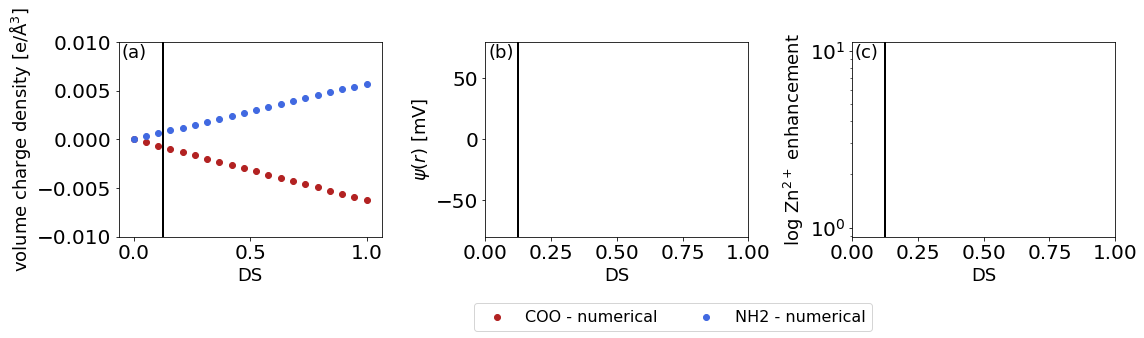

In [60]:
# iterate over funcationalities
if plot_summary:
    fig = plt.figure(figsize=(16, 4))
    ax1 = plt.subplot(131)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    # label
    ax1.text(0.01, 0.9, '(a)',
             verticalalignment='bottom', horizontalalignment='left',
             transform=ax1.transAxes,
             fontsize=18)
    ax2 = plt.subplot(132)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.text(0.01, 0.9, '(b)',
             verticalalignment='bottom', horizontalalignment='left',
             transform=ax2.transAxes,
             fontsize=18)
    ax3 = plt.subplot(133)
    ax3.tick_params(axis='both', which='major', labelsize=20)
    ax3.text(0.01, 0.9, '(c)',
             verticalalignment='bottom', horizontalalignment='left',
             transform=ax3.transAxes,
             fontsize=18)


func_surface_concentration = {}
for func in func_charges.keys():
    print("===================", func, "==================")
    # for plotting:
    if plot_summary:
        # calculate volume charge density as total charge / Volume
        Vg_q = func_total_charges[func] / Vg  # e/angstrom^3
        ax1.scatter(DS, Vg_q, c=func_colors[func])
   
    # collect data for each DS
    psi_= []
    continue    
    for i, ds in enumerate(DS):
        # calculate volume charge density as total charge / Volume
        Vg_q = func_total_charges[func][i] / Vg  # e/angstrom^3
              
        # initial solution guess
        if i == 0 or i == 1:
            solInit = pb_cylinder_init(r_r_in, sigr, kappar)
            y = solInit
        else:
            # use previous solution as input to current run
            y = solution.y

        # fun = RHS of system of ODEs
        # bc = boundary conditions
        # x = initial mesh
        # y = initial guess
        #sol = solve_bvp(pb_cylinder_ode(r,y,kappasqr), pb_cylinder_bc(r,y,sigr), r, y)#,p=[kappasqr,sigr])
        solution = solve_bvp(fun, bc, r_r_in, y)

        # reduced radial coord. (for output)        
        # reduced electrostatic potential
        # output the values of sol for all r
        psir = solution.sol(r_r_out)[0]
        poly = solution.sol
        dpsir = poly.derivative()(r_r_out)[0]

        # sol.stats
        # electrostatic potential [mV]
        psi = psir * Vt * 1000 
        psi_.append(psi)
        if plot_summary is False:
            plt.title(ds)
            plt.plot(r_r_out, psi)
            plt.show()

    if plot_summary:
        ax2.scatter(DS, [np.average(i[_dist_slice[0]:_dist_slice[1]]) for i in psi_], c=func_colors[func])
        
    # calculate avg concentration of zinc ions at the surface from psi(r)
    # within 1 Zinc radius 0.74 Ang from surface!
    # using boltzmann equation
    # c+/- = c+/-(bulk) * exp[-/+Z+/i*psi]
    zinc_conc = []
    zinc_counter_conc = []
    for i in psi_:   # SI
    #for i in ys:   # reduced
        surf_pot = np.average(i[_dist_slice[0]:_dist_slice[1]]) / 1000   # SI # in V
        z_c = calculate_conc(surf_pot, salt1_conc, Z1)   # SI
        z_counter_c = calculate_conc(surf_pot, salt2_conc, Z2)   # SI
        #surf_pot = np.average(i[1:5])   # reduced
        #z_c = calculate_reduced_conc(surf_pot, salt1_conc, Z1)   # reduced
        #z_counter_c = calculate_reduced_conc(surf_pot, salt2_conc, Z2)   # reduced
        zinc_conc.append(z_c)
        zinc_counter_conc.append(z_counter_c)
    # enhancement
    if plot_summary:
        ax3.scatter(DS, [i/salt1_conc for i in zinc_conc], c=func_colors[func])
    print("==========================================")
    
# format plots
# ax1.set_title('volume charge density', fontsize=18)
ax1.set_xlabel("DS", fontsize=18)
ax1.set_ylabel('volume charge density [e/$\mathrm{\AA}^3$]', fontsize=18)
ax1.axvline(x=0.125, c='k', lw=2)
ax1.set_ylim(-0.01, 0.01)

        
# ax2.set_title(r'surface potential', fontsize=18)
# ax2.set_xlabel("distance from cylinder surface [$\mathrm{\AA}$]", fontsize=18)
ax2.set_ylabel("$\psi(r)$ [mV]", fontsize=18)
ax2.set_xlabel("DS", fontsize=18)
ax2.axvline(x=0.125, c='k', lw=2)
ax2.set_xlim(0, 1)
ax2.set_ylim(-80, 80)

# ax3.set_title('surface Zn enhancement', fontsize=18)
ax3.set_xlabel("DS", fontsize=18)
ax3.set_ylabel("log Zn$^{2+}$ enhancement", fontsize=18)
ax3.set_yscale("log", nonposy='clip')
ax3.axvline(x=0.125, c='k', lw=2)

# legend
for func in func_charges.keys():
    ax2.scatter(-1000, -1000, c=func_colors[func], label=func+" - numerical")
    if plot_analytical is True:
        ax2.plot([-1000, -999], [-1000, -999], c=func_colors[func], label=func+" - analytical")

ax2.legend(fancybox=True, ncol=2, bbox_to_anchor=(1.5, -0.3),
           fontsize=16)
fig.tight_layout()
fig.savefig('../../documents/images/cylinder_model_spherical.pdf', dpi=720, bbox_inches='tight')